# Chess Dataset Analysis

Source: https://www.kaggle.com/datasets/milesh1/35-million-chess-games

Analyzing the rate at which new openings appear over ~3.5 million games ranging from 1950 - 2000.

# Imports

In [2]:
import csv
import collections
import io
import json
import re
import random
import datetime
import math

import numpy as np
import matplotlib.pyplot as plt

import tqdm

# Prepare Data

In [3]:
#1.t    2.date       3.result    4.welo      5.belo   6.len 7.date_c     8.resu_c      9.welo_c     10.belo_c 11.edate_c 12.setup 13.fen 14.resu2_c 15.oyrange 16.bad_len 17.game...
#1      2000.03.14   1-0         2851        None     67    date_false   result_false  welo_false   belo_true edate_true setup_false fen_false result2_false oyrange_false blen_false ### W1.d4 B1.d5 W2.c4 B2.e6 W3.Nc3 B3.Nf6 W4.cxd5 B4.exd5 W5.Bg5 B5.Be7 W6.e3 B6.Ne4 W7.Bxe7 B7.Nxc3 W8.Bxd8 B8.Nxd1 W9.Bxc7 B9.Nxb2 W10.Rb1 B10.Nc4 W11.Bxc4 B11.dxc4 W12.Ne2 B12.O-O W13.Nc3 B13.b6 W14.d5 B14.Na6 W15.Bd6 B15.Rd8 W16.Ba3 B16.Bb7 W17.e4 B17.f6 W18.Ke2 B18.Nc7 W19.Rhd1 B19.Ba6 W20.Ke3 B20.Kf7 W21.g4 B21.g5 W22.h4 B22.h6 W23.Rh1 B23.Re8 W24.f3 B24.Bb7 W25.hxg5 B25.fxg5 W26.d6 B26.Nd5+ W27.Nxd5 B27.Bxd5 W28.Rxh6 B28.c3 W29.d7 B29.Re6 W30.Rh7+ B30.Kg8 W31.Rbh1 B31.Bc6 W32.Rh8+ B32.Kf7 W33.Rxa8 B33.Bxd7 W34.Rh7+ 


In [3]:
# 1.t 2.date 3.result 4.welo 5.belo 6.len 7.date_c 8.resu_c 9.welo_c 10.belo_c 11.edate_c 12.setup 13.fen 14.resu2_c 15.oyrange 16.bad_len 17.game...
# 1 2000.03.14 1-0 2851 None 67 date_false result_false welo_false belo_true edate_true setup_false fen_false result2_false oyrange_false blen_false ### W1.d4 B1.d5 W2.c4 B2.e6 W3.Nc3 B3.Nf6 W4.cxd5 B4.exd5 W5.Bg5 B5.Be7 W6.e3 B6.Ne4 W7.Bxe7 B7.Nxc3 W8.Bxd8 B8.Nxd1 W9.Bxc7 B9.Nxb2 W10.Rb1 B10.Nc4 W11.Bxc4 B11.dxc4 W12.Ne2 B12.O-O W13.Nc3 B13.b6 W14.d5 B14.Na6 W15.Bd6 B15.Rd8 W16.Ba3 B16.Bb7 W17.e4 B17.f6 W18.Ke2 B18.Nc7 W19.Rhd1 B19.Ba6 W20.Ke3 B20.Kf7 W21.g4 B21.g5 W22.h4 B22.h6 W23.Rh1 B23.Re8 W24.f3 B24.Bb7 W25.hxg5 B25.fxg5 W26.d6 B26.Nd5+ W27.Nxd5 B27.Bxd5 W28.Rxh6 B28.c3 W29.d7 B29.Re6 W30.Rh7+ B30.Kg8 W31.Rbh1 B31.Bc6 W32.Rh8+ B32.Kf7 W33.Rxa8 B33.Bxd7 W34.Rh7+ 
def get_games():
    dates_and_games = []
    stats = collections.defaultdict(int)
    with open("data/all_with_filtered_anotations_since1998.txt") as handle:
        for line in tqdm.tqdm(handle):
            try:
                if not line or line.startswith("#"):
                    continue
                # for now we only focus on the date and result of the game as well as the moves.
                date_str = re.findall("\d{4}\.\d{2}\.\d{2}", line[:30])[0]
                date = datetime.datetime.strptime(date_str, "%Y.%m.%d")
                result = re.findall(r"0-1|1-0|0\.5-0\.5", line[:30])[0]
                moves = line.split("###")[1].strip()
                dates_and_games.append(
                    {
                        "date": date,
                        "result": result,
                        "moves":moves,
                    }
                )
                stats['success'] += 1
            except Exception as exc:
                stats[str(exc)] += 1

        return sorted(dates_and_games, key=lambda x: x["date"]), stats
    
games, stats = get_games()
print(f"{100 * stats['success'] / sum(stats.values())}% success rate, {len(games)} games obtained.")

3561475it [01:03, 56063.46it/s]


30.601212420713917% success rate, 1089853 games obtained.


In [4]:
def filter_games(games):
    """
    Apply some sanity checks
    """
    return [g  for g in games if
            "W10." in g["moves"] and  # the game consists of at least 10 moves from a player
            g['date'] > datetime.datetime(1980,1,1)  # the date is not obviously broken such as 206.01.01
    ]

games_filtered = filter_games(games)
len(games_filtered)





1020412

# Base stats

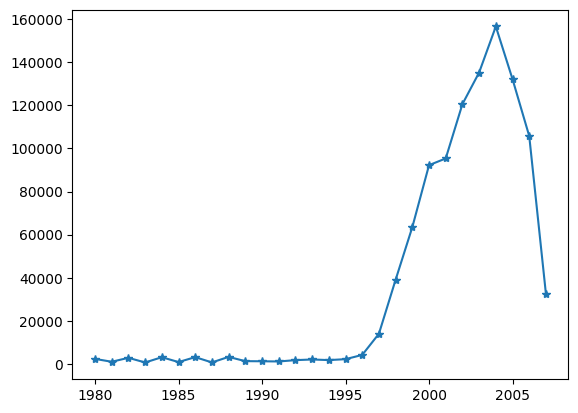

In [46]:
cc = collections.Counter([int(g['date'].year) for g in games_filtered])
plt.plot(sorted(cc.keys()), [cc[x] for x in sorted(cc.keys())], "*-")

100%|██████████████████████████████| 1020412/1020412 [00:24<00:00, 42033.43it/s]


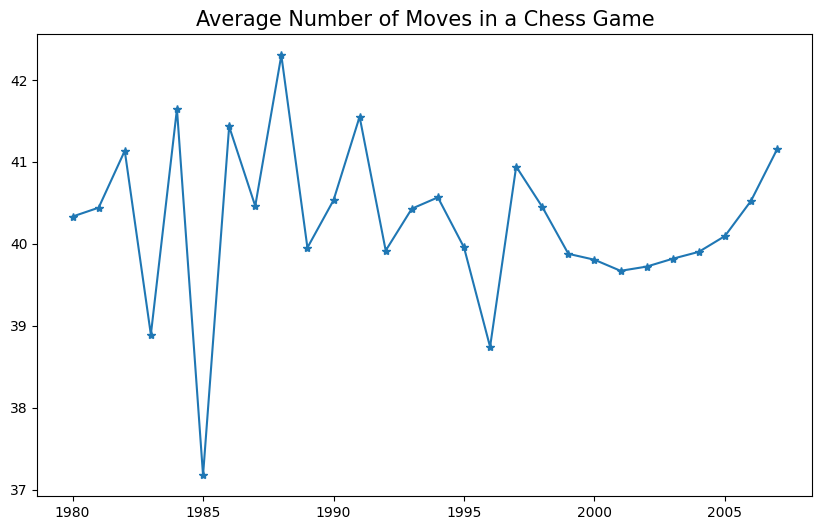

In [7]:
annual_moves = collections.defaultdict(list)
for game in tqdm.tqdm(games_filtered):
    annual_moves[int(game['date'].year)].append(int(
        re.findall('(\d{1,2})\.', game['moves'])[-1]
    ))

plt.figure(figsize=(10,6))
plt.title("Average Number of Moves in a Chess Game", fontsize=15)

plt.plot(annual_moves.keys(), [sum(annual_moves[k])/ max(1, len(annual_moves[k])) for k in annual_moves], "*-")

# Growth of Different Openings

In [5]:
 def get_moves_only(game):
    return [move.split(".")[1] for move in game['moves'].split(" ")]

In [6]:
MOVE_COUNTS = range(1,11)

have_seen = {move_count: set() for move_count in MOVE_COUNTS}
counts = {move_count: [] for move_count in MOVE_COUNTS}

for index, game in tqdm.tqdm(enumerate(games_filtered)):
    moves_only = get_moves_only(game)
    for move_count in MOVE_COUNTS:
        init_moves = moves_only[:2 * move_count]
        move_hash = "".join(init_moves)
        have_seen[move_count].add(move_hash)
        counts[move_count].append(len(have_seen[move_count]))

1020412it [00:41, 24480.69it/s]


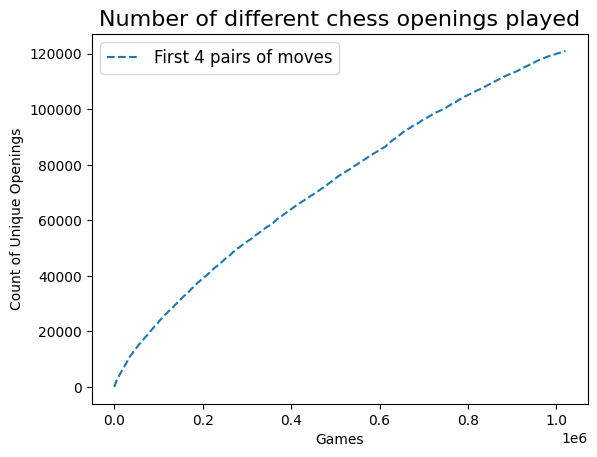

In [10]:
plt.figure()
plt.title(f"Number of different chess openings played", fontsize=16)
plt.xlabel("Games")
plt.ylabel("Count of Unique Openings")

MOVE_COUNTS = [4]
for index, move_count in enumerate(MOVE_COUNTS):
    plt.plot(range(len(counts[move_count])), counts[move_count],"--", label=f"First {move_count} pairs of moves")    
   
plt.legend(fontsize=12)
#plt.xlim(1, 50_000)
#plt.ylim(1, 15_000)

# Heatmaps of various field properties

In [9]:
def field_to_coordinates(field):
    return (8 - int(field[1]), 'abcdefgh'.index(field[0]))

## Captures

100%|█████████████████████████████| 1020412/1020412 [00:06<00:00, 151789.21it/s]


Text(0.5, 1.0, 'Capture Frequency on the Chess Board')

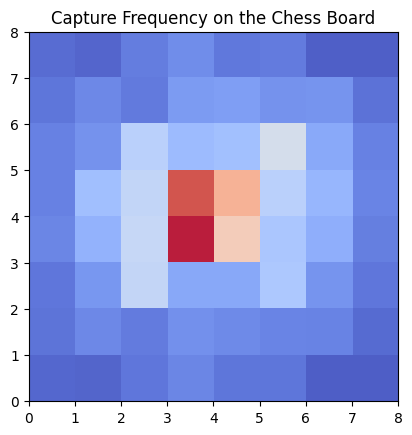

In [10]:
capture_fields = collections.defaultdict(int)
for game in tqdm.tqdm(games_filtered):
    for capture in re.findall("x([a-z][1-8])", game['moves']):
        capture_fields[capture] += 1
          

fig, ax = plt.subplots()
chessboard = np.zeros((8, 8))
#chessboard[1::2, 0::2] = 1
#chessboard[0::2, 1::2] = 1

ax.imshow(chessboard, cmap='binary', interpolation='nearest', extent=[0, 8, 0, 8])

data = np.array([
    np.array([0 for y in range(8)])
    for x in range(8)
])
for k, v in capture_fields.items():
    data[field_to_coordinates(k)] = v

im = ax.imshow(data, alpha=0.9, cmap='coolwarm', interpolation='nearest', extent=[0, 8, 0, 8])
ax.set_title("Capture Frequency on the Chess Board")

## Losing King's position at the time of checkmate

In [11]:
# NOTE: this is a very small subset of games; normally GMs resigns way before checkmate can happen
checkmate_games = [g for g in games_filtered if g['moves'][-1] == "#"];len(checkmate_games)

67325

In [36]:
stats = collections.defaultdict(int)
white_checkmate_fields = collections.defaultdict(int)
black_checkmate_fields = collections.defaultdict(int)

for game in checkmate_games:
    # find the losing king's last known position such as W20.Ke3
    if game['result'] not in ['1-0', '0-1']:
        stats['wrong'] += 1
        continue
    if game['result'] == '1-0':
        king_positions = re.findall("B\d{1,3}\.K(?:x)?[abcdefgh][12345678]", game['moves'])
        king_last_seen = king_positions[-1] if king_positions else 'e8'
        stats['white'] +=1
        black_checkmate_fields[king_last_seen[-2:]] += 1
    elif game['result'] == '0-1':
        king_positions = re.findall("W\d{1,3}\.K(?:x)?[abcdefgh][12345678]", game['moves'])
        king_last_seen = king_positions[-1] if king_positions else 'e1'
        stats['black'] += 1
        white_checkmate_fields[king_last_seen[-2:]] += 1
stats

defaultdict(int, {'black': 30849, 'white': 36476})

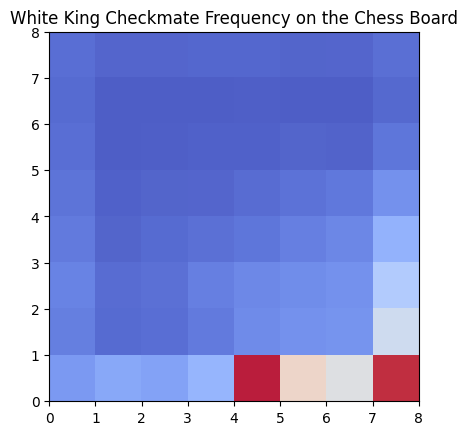

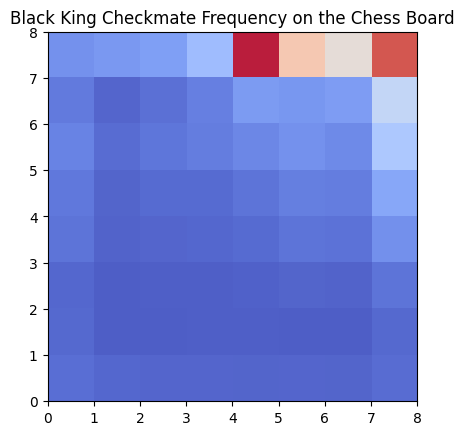

In [44]:
for color, checkmate_fields in {
    'White': white_checkmate_fields,
    "Black": black_checkmate_fields,
}.items():
    fig, ax = plt.subplots()
    chessboard = np.zeros((8, 8))
    #chessboard[1::2, 0::2] = 1
    #chessboard[0::2, 1::2] = 1

    ax.imshow(chessboard, cmap='binary', interpolation='nearest', extent=[0, 8, 0, 8])

    data = np.array([
        np.array([0 for y in range(8)])
        for x in range(8)
    ])
    for k, v in checkmate_fields.items():
        data[field_to_coordinates(k)] = v

    im = ax.imshow(data, alpha=0.9, cmap='coolwarm', interpolation='nearest', extent=[0, 8, 0, 8])
    ax.set_title(f"{color} King Checkmate Frequency on the Chess Board")

# FICS GAMES DB